Урок 6. Сегментация
---

**Домашнее задание**:
Используя файл Web6.ipynb (он в полезных ссылках):

Попробуйте обучить нейронную сеть U-Net на любом другом датасете. Можете взять один из этих наборов данных:
https://www.kaggle.com/carlolepelaars/camvid

https://www.kaggle.com/dansbecker/cityscapes-image-pairs

https://www.kaggle.com/tapakah68/segmentation-full-body-mads-dataset

https://www.kaggle.com/longnguyen2306/bacteria-detection-with-darkfield-microscopy

https://www.kaggle.com/nikhilpandey360/chest-xray-masks-and-labels

Опишите в комментарии - какого результата вы добились от нейросети? Что помогло вам улучшить ее точность?

In [1]:
# !pip install opencv-python

In [2]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
import os

import tensorflow as tf
import keras

from keras.layers.normalization import BatchNormalization
from keras.layers import Input, Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, UpSampling2D, Concatenate
from keras.layers.convolutional import Conv2D
from keras.models import Sequential, Model, model_from_json, load_model
from keras.regularizers import l2

(256, 512, 3)
2975


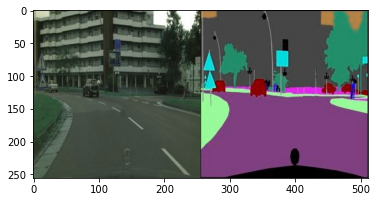

In [3]:
path = '../../data/kaggle/cityscapes_data/train/'
flist = os.listdir(path)
img0 = cv2.imread(path+flist[0])
plt.imshow(img0)
print(np.shape(img0))
print(len(flist))

In [4]:
# чтение картинок и создание тренировочного датасета
szy, szx, _ = np.shape(img0)
N_ex = 1500 # берём часть датасета, чтобы нейронке хватило памяти
N_bias = 0
x_train = np.zeros((N_ex, szy, int(szx/2), 3))
y_train = np.zeros((N_ex, szy, int(szx/2), 3))
k = 0

for f in flist[N_bias:N_bias+N_ex]:
    x_train[k] = cv2.imread(path+f)[:,:256]/256
    y_train[k] = cv2.imread(path+f)[:,256:]/256
    k = k+1

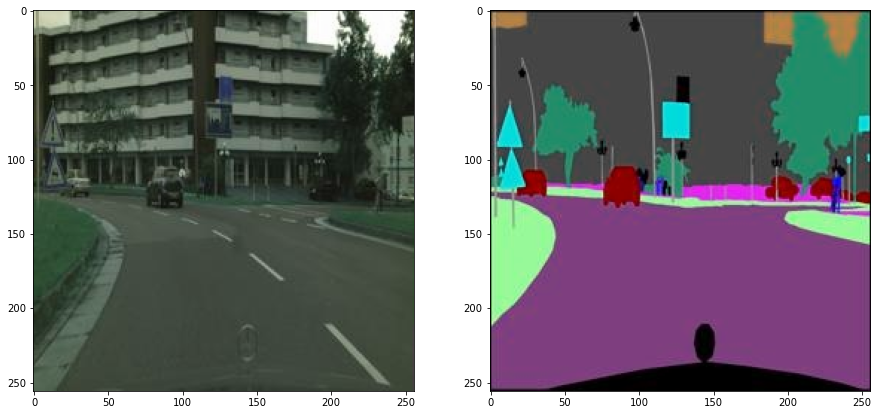

In [5]:
plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.imshow(x_train[0])
plt.subplot(1,2,2)
plt.imshow(y_train[0]);

In [6]:
# то же самое для тренировчных данных
path = '../../data/kaggle/cityscapes_data/train/'
flist = os.listdir(path)
img0 = cv2.imread(path+flist[0])
N_val = 100 # берём часть датасета, чтобы нейронке хватило памяти

szy,szx,_ = np.shape(img0)
x_val = np.zeros((N_val,szy,int(szx/2),3))
y_val = np.zeros((N_val,szy,int(szx/2),3))
k = 0;

for f in flist[0:N_val]:
    x_val[k] = cv2.imread(path+f)[:,:256]/256
    y_val[k] = cv2.imread(path+f)[:,256:]/256
    k = k+1

In [7]:
#u-net architecture

# define conv_factory: batch normalization + ReLU + Conv2D + Dropout (optional)
def conv_factory(x, concat_axis, nb_filter,
                 dropout_rate=None, weight_decay=1E-4):
    x = BatchNormalization(axis=concat_axis,
                           gamma_regularizer=l2(weight_decay),
                           beta_regularizer=l2(weight_decay))(x)
    x = Activation('relu')(x)
    x = Conv2D(nb_filter, (5, 5), dilation_rate=(2, 2),
               kernel_initializer="he_uniform",
               padding="same",
               kernel_regularizer=l2(weight_decay))(x)
    if dropout_rate:
        x = Dropout(dropout_rate)(x)
  
    return x


# define dense block: a nb_layers stack of conv_factory layers merged together
def denseblock(x, concat_axis, nb_layers, growth_rate, dropout_rate=None, weight_decay=1E-4):
    list_feat = [x]
    for i in range(nb_layers):
        x = conv_factory(x, concat_axis, growth_rate,dropout_rate, weight_decay)
        list_feat.append(x)
    x = Concatenate(axis=concat_axis)(list_feat)

    return x


# define model U-net modified with dense block
def u_net():
    dr = 0.5
    nr = 2
    mod_inputs = Input((256,256,3))
    print("inputs shape:", mod_inputs.shape) #input layer

    conv1 = Conv2D(64/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mod_inputs)
    print("conv1 shape:", conv1.shape)
    db1 = denseblock(x=conv1, concat_axis=3, nb_layers=4, growth_rate=16, dropout_rate=dr)
    print("db1 shape:", db1.shape)
    pool1 = MaxPooling2D(pool_size=(2, 2))(db1)
    print("pool1 shape:", pool1.shape)

    conv2 = Conv2D(128/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    print("conv2 shape:", conv2.shape)
    db2 = denseblock(x=conv2, concat_axis=3, nb_layers=4, growth_rate=16, dropout_rate=dr)
    print("db2 shape:", db2.shape)
    pool2 = MaxPooling2D(pool_size=(2, 2))(db2)
    print("pool2 shape:", pool2.shape)

    conv3 = Conv2D(256/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    print("conv3 shape:", conv3.shape)
    db3 = denseblock(x=conv3, concat_axis=3, nb_layers=4, growth_rate=16, dropout_rate=dr)
    print("db3 shape:", db3.shape)
    pool3 = MaxPooling2D(pool_size=(2, 2))(db3)
    print("pool3 shape:", pool3.shape)

    conv4 = Conv2D(512/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    print("conv4 shape:", conv4.shape)
    db4 = denseblock(x=conv4, concat_axis=3, nb_layers=4, growth_rate=16, dropout_rate=dr)
    print("db4 shape:", db4.shape)
    pool4 = MaxPooling2D(pool_size=(2, 2))(db4)
    print("pool4 shape:", pool4.shape)
#################this is the bottleneck######################################
    conv5 = Conv2D(1024/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    print("conv5 shape:", conv5.shape)
    db5 = denseblock(x=conv5, concat_axis=3, nb_layers=3, growth_rate=16, dropout_rate=dr)
    print("db5 shape:", db5.shape)
    up5 = Conv2D(512/nr, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(db5))
    print("up5 shape:", up5.shape)
    merge5 = Concatenate(axis=3)([ BatchNormalization()(db4), BatchNormalization()( up5)]) #skip connection db4 to up5
    print("merge5 shape:", merge5.shape)

    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge5)
    print("conv6 shape:", conv6.shape)
    db6 = denseblock(x=conv6, concat_axis=3, nb_layers=3, growth_rate=16, dropout_rate=dr)
    print("db5 shape:", db6.shape)
    up6 = Conv2D(256/nr, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(db6))
    print("up6 shape:", up6.shape)
    merge6 = Concatenate(axis=3)([BatchNormalization()(db3), BatchNormalization()(up6)]) #skip connection db3 to up6
    print("merge6 shape:", merge6.shape)

    conv7 = Conv2D(256/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    print("conv7 shape:", conv7.shape)
    db7 = denseblock(x=conv7, concat_axis=3, nb_layers=2, growth_rate=16, dropout_rate=dr)
    print("db7 shape:", db7.shape)
    up7 = Conv2D(128/nr, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(db7))
    print("up7 shape:", up7.shape)
    merge7 = Concatenate(axis=3)([BatchNormalization()(db2), BatchNormalization()(up7)]) #skip connection db2 to up7
    print("merge7 shape:", merge7.shape)

    conv8 = Conv2D(128/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    print("conv8 shape:", conv8.shape)
    db8 = denseblock(x=conv8, concat_axis=3, nb_layers=2, growth_rate=16, dropout_rate=dr)
    print("db8 shape:", db8.shape)
    up8 = Conv2D(64/nr, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(db8))
    print("up8 shape:", up8.shape)
    merge8 = Concatenate(axis=3)([BatchNormalization()(db1), BatchNormalization()(up8)]) #skip connection db1 to up8
    print("merge8 shape:", merge8.shape)

    conv9 = Conv2D(64/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    print("conv9 shape:", conv9.shape)
    db9 = denseblock(x=conv9, concat_axis=3, nb_layers=2, growth_rate=16, dropout_rate=dr)
    print("db9 shape:", db9.shape)
    conv10 = Conv2D(32/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(db9) # final node layer
    print("conv10 shape:", conv10.shape)
    conv11 = Conv2D(3, 1, activation='sigmoid')(conv10)  #output layer matched in size with the input
    print("conv11 shape:", conv11.shape)

    model = Model(inputs=mod_inputs, outputs=conv11) 
    model.compile(optimizer='adam', loss = 'MSE')
    
    return model

In [8]:
model = u_net()

inputs shape: (None, 256, 256, 3)
conv1 shape: (None, 256, 256, 32)
db1 shape: (None, 256, 256, 96)
pool1 shape: (None, 128, 128, 96)
conv2 shape: (None, 128, 128, 64)
db2 shape: (None, 128, 128, 128)
pool2 shape: (None, 64, 64, 128)
conv3 shape: (None, 64, 64, 128)
db3 shape: (None, 64, 64, 192)
pool3 shape: (None, 32, 32, 192)
conv4 shape: (None, 32, 32, 256)
db4 shape: (None, 32, 32, 320)
pool4 shape: (None, 16, 16, 320)
conv5 shape: (None, 16, 16, 512)
db5 shape: (None, 16, 16, 560)
up5 shape: (None, 32, 32, 256)
merge5 shape: (None, 32, 32, 576)
conv6 shape: (None, 32, 32, 512)
db5 shape: (None, 32, 32, 560)
up6 shape: (None, 64, 64, 128)
merge6 shape: (None, 64, 64, 320)
conv7 shape: (None, 64, 64, 128)
db7 shape: (None, 64, 64, 160)
up7 shape: (None, 128, 128, 64)
merge7 shape: (None, 128, 128, 192)
conv8 shape: (None, 128, 128, 64)
db8 shape: (None, 128, 128, 96)
up8 shape: (None, 256, 256, 32)
merge8 shape: (None, 256, 256, 128)
conv9 shape: (None, 256, 256, 32)
db9 shape: (No

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [11]:
hist = model.fit(x_train, y_train, epochs=1, shuffle = True, batch_size= 10, validation_data=(x_val, y_val))

150/150 [==============================] - 3215s 21s/step - loss: 0.1674 - val_loss: 0.1801


In [21]:
hist.history

{'loss': [0.16736911237239838], 'val_loss': [0.18011023104190826]}

In [ ]:
plt.plot(hist.history['val_dice_coef'], label='test')
plt.plot(hist.history['dice_coef'], label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

In [24]:
pred = model.predict(x_val)
print(pred.shape)

(100, 256, 256, 3)


In [30]:
n = 1
class_ = 1
plt.imshow(flist[N_val + n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(masks[N + n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = y_test[n][..., class_]
plt.imshow(img)
plt.title('целевая разметка класс: ' + str(class_))
plt.show()
img = pred[n][..., class_]
plt.imshow(img)
plt.title('предиктивная разметка класс: ' + str(class_))
plt.show()

AttributeError: 'str' object has no attribute 'convert'

In [31]:
pp_nc = model.predict(x_val[0:20,:,:,:])

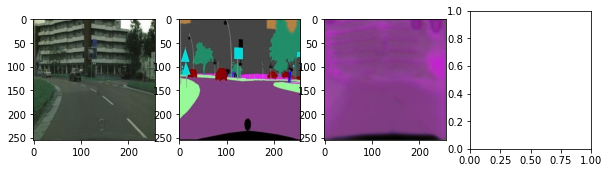

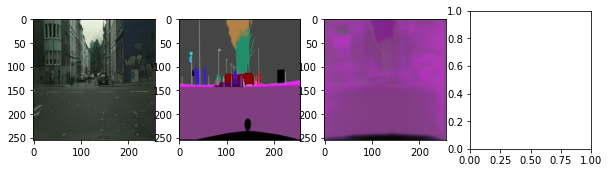

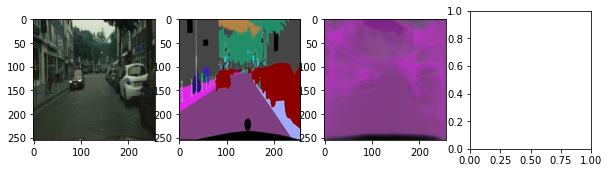

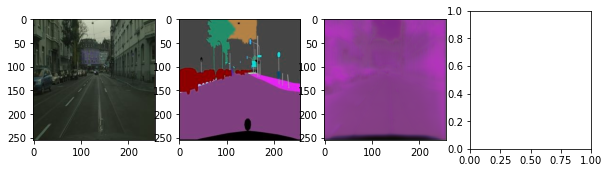

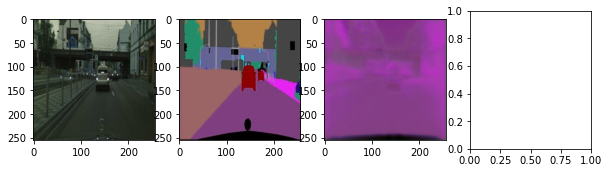

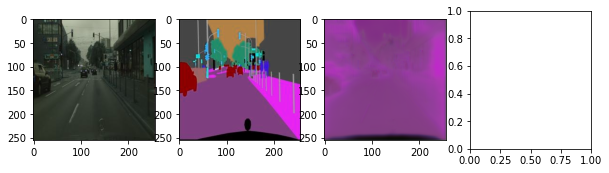

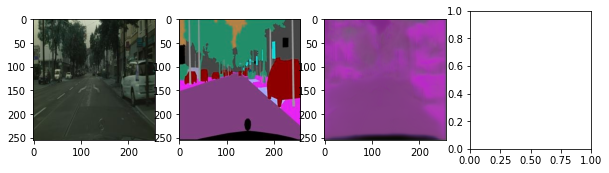

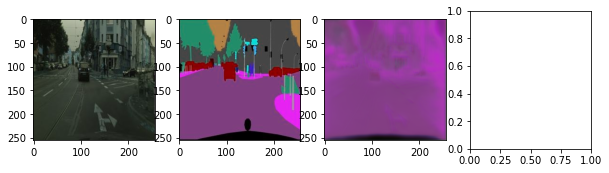

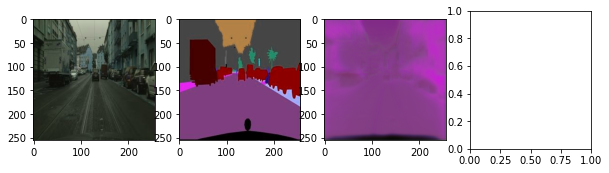

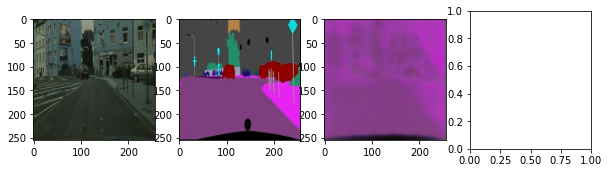

In [33]:
ni = 10
for k in range(ni):

    plt.figure(figsize=(10,30))
    plt.subplot(ni,4,1+k*4)
    plt.imshow(x_val[k])
    plt.subplot(ni,4,2+k*4)
    plt.imshow(y_val[k])
    plt.subplot(ni,4,3+k*4)
    plt.imshow(pp_nc[k]) #without skips
    plt.subplot(ni,4,4+k*4)
#    plt.imshow(pp[k]) #with skips